# Importing Modules and Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.losses import CategoricalCrossentropy
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy,F1Score,Precision,Recall
from tensorflow.keras.layers import Conv2D,Input,MaxPool2D,Dense,BatchNormalization,Flatten,Dropout,GlobalAveragePooling2D,GlobalMaxPool2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Plotting Images

In [2]:
path="/kaggle/input/emotion-dataset/Emotion Dataset/Surprise"
sample_files=[os.path.join(path,i) for i in os.listdir(path)]

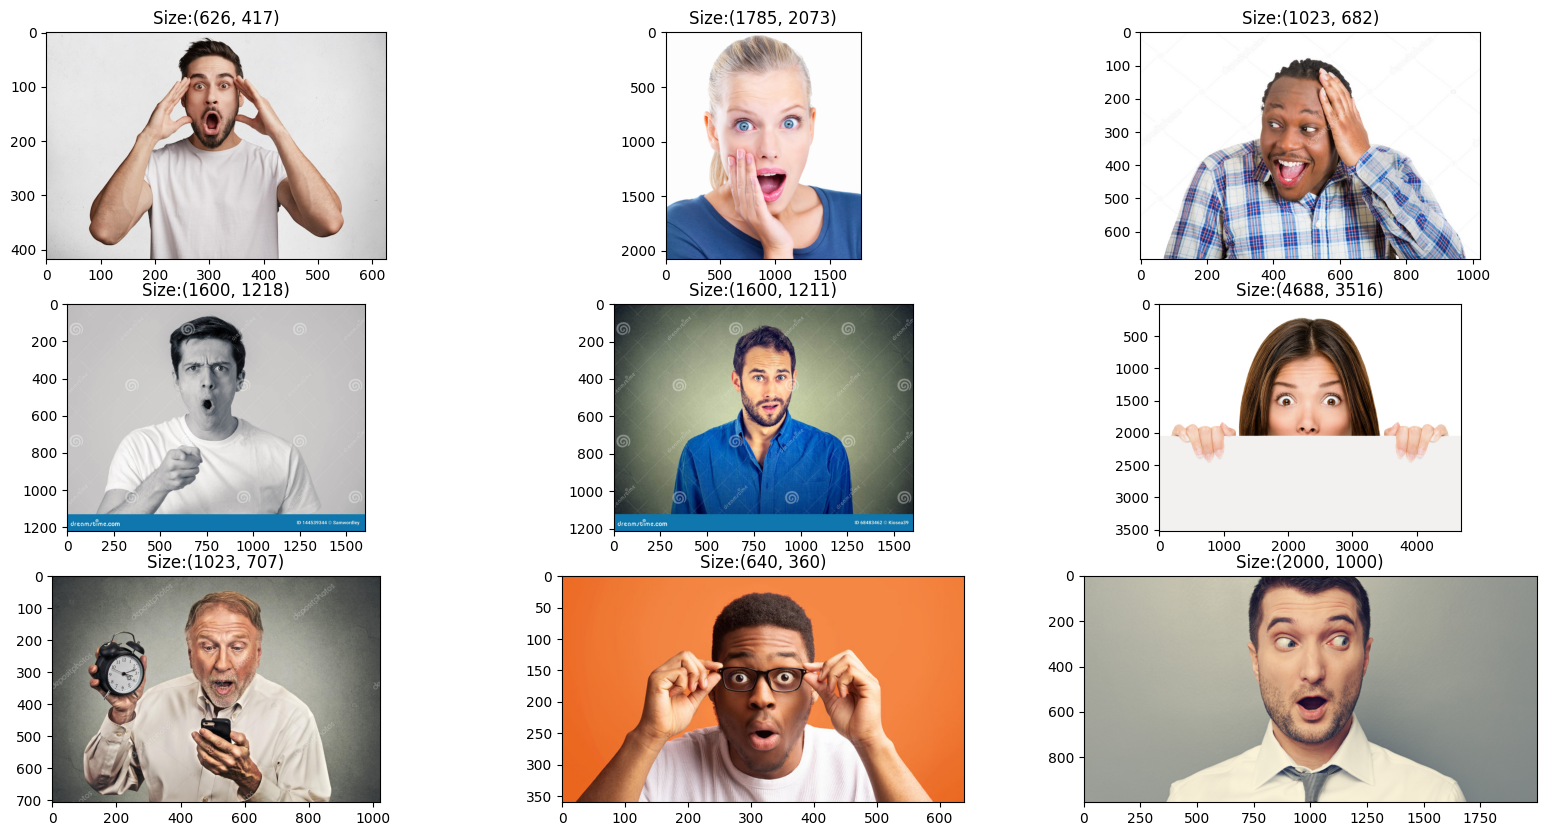

In [3]:
fig,axis=plt.subplots(3,3,figsize=(20,10))
axis=axis.flatten()
count=0
rand_indices=np.random.randint(0,len(sample_files),size=(9,1)).flatten()
for i in range(len(rand_indices)):
    image=load_img(sample_files[rand_indices[i]])
    axis[count].imshow(image)
    axis[count].set_title("Size:"+str(image.size))
    count+=1

> Choosen Image Size is (512,512) 

# Configuration

In [4]:
CONFIG={
    "BATCH_SIZE":16,
    "IMG_SIZE":(512,512),
    "STRIDE_1":1,
    "STRIDE_2":2,
    "REGUL":0.001,
    "DROP_OUT":0.2,
    "DENSE_L1":1024,
    "DENSE_L2":512,
    "DENSE_L3":256,
    "DENSE_L4":128,
    "KERNEL_SIZE_3":(3,3),
    "KERNEL_SIZE_2":(5,5),
    "KERNEL_SIZE_1":(7,7),
    "LR":0.001,
    "CLASS_NAMES":['Happy','Sad','Surprise'],
    "POOL_SIZE":(2,2),
    "train_path":"/kaggle/input/emotion-dataset/Emotion Dataset/",
    
    "FILTERS":32
    
}

# Generators for image loading

In [5]:
img_gen=ImageDataGenerator(rescale=1/255.0,shear_range=0.1,zoom_range=0.1,validation_split=0.2)

In [6]:
train_gen=img_gen.flow_from_directory(directory=CONFIG["train_path"],target_size=CONFIG["IMG_SIZE"],batch_size=CONFIG['BATCH_SIZE'],shuffle=True,class_mode='categorical',color_mode='rgb',subset='training')

Found 381 images belonging to 3 classes.


In [7]:
val_gen=img_gen.flow_from_directory(directory=CONFIG["train_path"],target_size=CONFIG["IMG_SIZE"],batch_size=CONFIG['BATCH_SIZE'],shuffle=True,class_mode='categorical',subset='validation',color_mode='rgb')

Found 94 images belonging to 3 classes.


In [8]:
x,y=next(train_gen)

# Plotting Generator Images

In [9]:
images=x
labels=np.argmax(y,axis=-1)

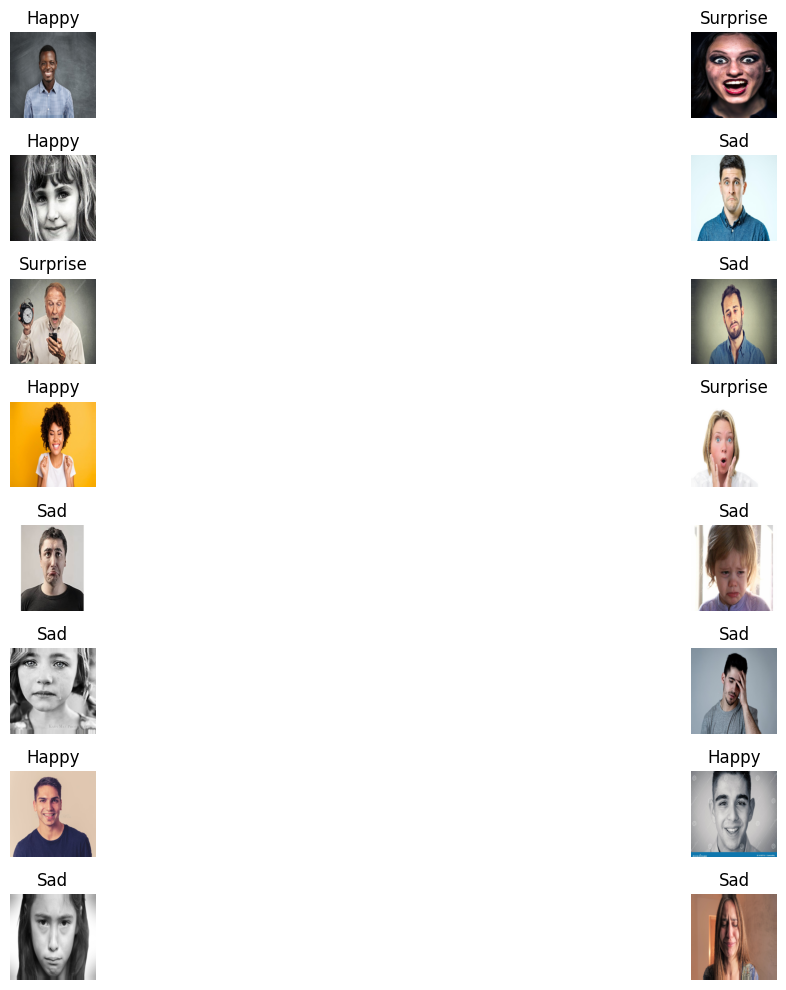

In [10]:
fig,axis=plt.subplots(8,2,figsize=(20,10))
axis=axis.flatten()
count=0
for i in range(len(labels)):

    axis[count].imshow(images[i],cmap='gray')
    title=CONFIG['CLASS_NAMES'][labels[i]]
    axis[count].set_title(title)
    axis[count].axis('off')
    count+=1
    
plt.tight_layout()


# Model Architecture

In [11]:
def get_model(input_shape=(512,512,3)):
    i=Input(shape=input_shape)
    x=Conv2D(filters=32,activation='relu',kernel_size=5)(i)
    x=MaxPool2D(pool_size=2)(x)
    x=Conv2D(filters=32,activation='relu',kernel_size=3)(x)
    x=MaxPool2D(pool_size=2)(x)
    x=GlobalMaxPool2D()(x)
    x=Dense(units=1024,activation='relu')(x)
    x=Dense(units=256,activation='relu')(x)
    x=Dense(3,activation='softmax',name='last_layer')(x)
    return Model(i,x)
model=get_model()

# Model Summary

In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 508, 508, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 252, 252, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_layer (Dense)              │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,643 (1.18 MB)

 Trainable params: 308,643 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

# Compilation of model

In [13]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=Adam(learning_rate=CONFIG['LR']))

In [14]:
steps_per_epoch=len(train_gen)
validation_steps=94//16

# Callbacks

In [15]:
callbacks=[ReduceLROnPlateau(monitor='val_loss',mode='min',patience=6,verbose=1),
           ModelCheckpoint(filepath='/kaggle/working/checked_model.keras',monitor='val_loss',mode='min',save_best_only=True,save_freq='epoch')]

# Model Fitting

In [16]:
model.fit(train_gen,batch_size=CONFIG['BATCH_SIZE'],epochs=40,callbacks=callbacks,validation_data=val_gen,steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726843067.856956      80 service.cc:145] XLA service 0x7a0a4c004660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726843067.857019      80 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.3750 - loss: 1.0832 

I0000 00:00:1726843073.772164      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.3531 - loss: 1.1261 - val_accuracy: 0.4000 - val_loss: 1.0912 - learning_rate: 0.0010
Epoch 2/40


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2143 - val_loss: 1.1022 - learning_rate: 0.0010
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 986ms/step - accuracy: 0.3784 - loss: 1.0937 - val_accuracy: 0.4000 - val_loss: 1.0792 - learning_rate: 0.0010
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4286 - val_loss: 1.0829 - learning_rate: 0.0010
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 965ms/step - accuracy: 0.3916 - loss: 1.0927 - val_accuracy: 0.3875 - val_loss: 1.0867 - learning_rate: 0.0010
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3571 - val_loss: 1.0724 - learning_rate: 0.0010
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.3950 - loss: 1.0815 - val_accuracy: 0.3625 - val_loss: 1.0823 - learning_rate: 0.0010
Epoch 8/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0000e+00 - lo

# Model Prediction

In [17]:

def preprocess(path):
    image=Image.open(path)
    image=image.resize((512,512))
    image=np.array(image)
    image=image/255.0
    return image

In [18]:
path_list=[]
path='/kaggle/input/emotion-detection-test-dataset/Emotion Detection Test Dataset/'
for i in sorted(os.listdir(path)):
    path_list.append(path+i)

In [19]:
batched_array=[]
for i in range(len(path_list)):
    batched_array.append(preprocess(path_list[i]))
batched_array=np.array(batched_array)


In [20]:
predicted=np.argmax(model.predict(batched_array),axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step


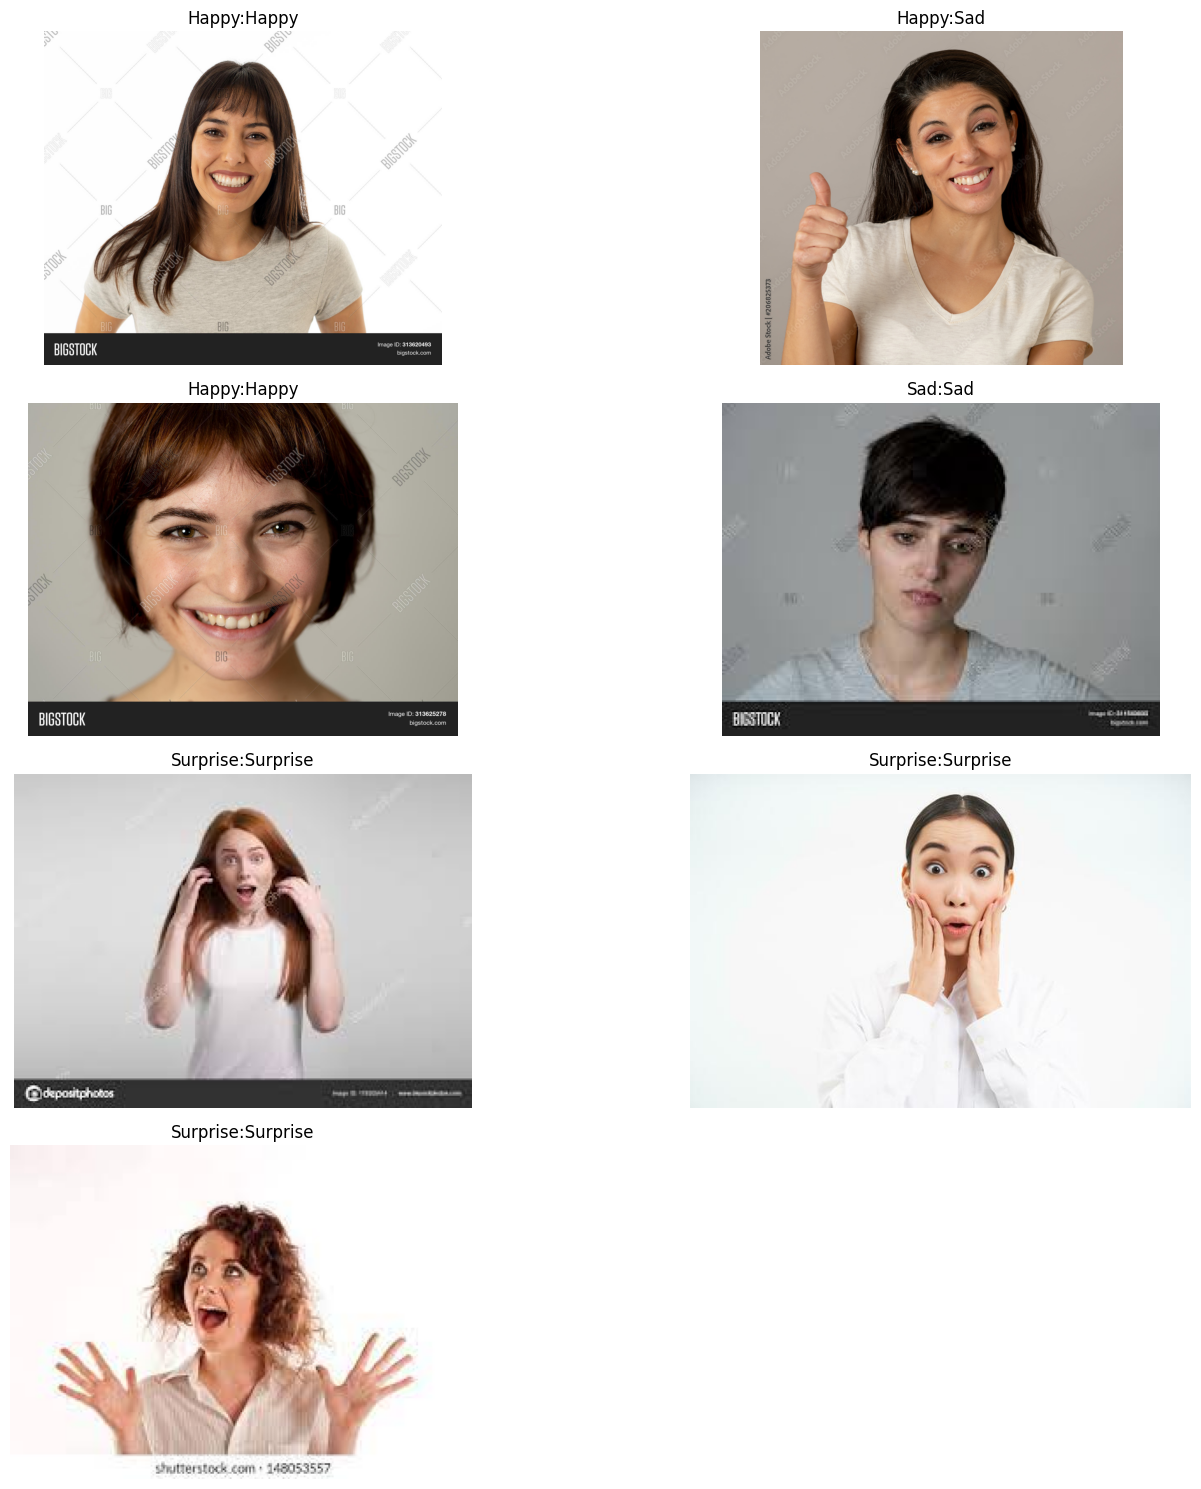

In [21]:
True_labels=['Happy','Happy','Happy','Sad','Surprise','Surprise','Surprise']
class_indices={0:'Happy', 1:'Sad', 2:'Surprise'}
fig,axis=plt.subplots(4,2,figsize=(15,15))
axis=axis.flatten()
for i in range(len(path_list)):
    axis[i].imshow(Image.open(path_list[i]))
    axis[i].set_title(True_labels[i]+":"+class_indices[predicted[i]])
    axis[i].set_axis_off()
fig.delaxes(axis[7])
plt.tight_layout()